# Steady flow control test case

#### *Paper*:        Real-time optimal control of high-dimensional parametrized systems by deep learning-based reduced order models
#### *Authors*:      M.Tomasetto, A.Manzoni, F.Braghin
#### *Affiliations*: Department of Mechanical Engineering (Politecnico di Milano), MOX - Department of Mathematics (Politecnico di Milano)

In [2]:
#IMPORT LIBRARIES

from dolfin import *
from dolfin_adjoint import *
import gmsh
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from IPython.display import clear_output as clc

from dlroms.cores import CPU, GPU # Cores swapping
import dlroms.fespaces as fe # Finite element spaces handling
import dlroms.geometry as geo # Mesh creation
from dlroms.roms import num2p # Percentage format

import seaborn as sns
teal = sns.light_palette("teal", 15)
magenta = sns.dark_palette("magenta", 15)
red = sns.light_palette("orangered", 15)
navy = sns.light_palette("navy", 15)

set_log_level(LogLevel.ERROR)

# State problem

Steady Navier-Stokes equations
\begin{cases}
       -\mu \Delta \boldsymbol{v} + (\boldsymbol{v} \cdot \nabla) \boldsymbol{v} + \nabla p = 0  \qquad &\mathrm{in} \ \Omega \\
       \mathrm{div }\  \boldsymbol{v} = 0  \qquad &\mathrm{in} \ \Omega  \\
       \boldsymbol{v} = \boldsymbol{u}  \qquad &\mathrm{on} \ \Gamma_{\textrm{c}} \\
       \boldsymbol{v} = \boldsymbol{0}  \qquad &\mathrm{on} \ \Gamma_{\textrm{obs}} \\
       \boldsymbol{v} = \boldsymbol{v}_{\text{in}}((\boldsymbol{\mu}_s))  \qquad &\mathrm{on} \ \Gamma_{\textrm{in}} \\
       \boldsymbol{v} \cdot \boldsymbol{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \\
       (\mu \nabla \boldsymbol{v} - pI)\boldsymbol{n} \cdot \boldsymbol{t} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \\
       (\mu \nabla \boldsymbol{v} - pI)\boldsymbol{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{out}} \\
\end{cases}

where $\Omega$ is the domain of interest, $\mathbf{v}: \Omega \to \mathbb R^2$ is the unknown velocity, $p:  \Omega \to \mathbb R$ is the unknown pressure, $\mathbf{u}:  \Gamma_c \to \mathbb R^2$ is the control variable that specifies the Dirichlet boundary condition on the rounded edge of the obstacle $\Gamma_c$, $\mathbf{v}_{\text{in}}: \Gamma_{\textrm{in}} \to \mathbb R^2$ is the inflow datum depending on scenario parameters $\boldsymbol{\mu}_s$, $\mu$ is the kynematic viscosity, $\mathbf{n}$ and $\mathbf{t}$ are the normal and tangential versors

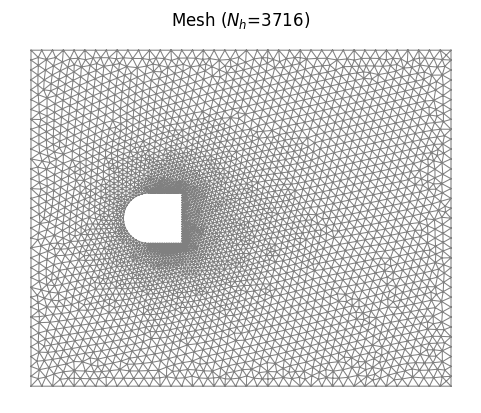

In [3]:
# IMPORT THE MESH FOR THE STATE PROBLEM

mesh = Mesh("Mesh/mesh.xml")
plot(mesh, color = "grey", linewidth = 0.75)
plt.axis("off");
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices());

In [4]:
# DEFINE AND MARK SUBDOMAINS AND BOUNDARY PORTIONS

dx = Measure("dx", domain = mesh) # Domain measure

class GammaOBS(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        return on_boundary and between(x[1], (7.0, 13.0)) and between(x[0], (4.0, 10.0))
class GammaC(SubDomain):   # Control boundary
    def inside(self, x, on_boundary):
        return on_boundary and between(x[1], (7.0, 13.0)) and between(x[0], (4.0, 7.0))   
boundaries_state = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries_state.set_all(0)
GammaOBS().mark(boundaries_state, 1)
GammaC().mark(boundaries_state, 2)
ds = Measure("ds", domain = mesh, subdomain_data = boundaries_state) # Boundary measure

In [5]:
# DEFINE THE STATE SPACE

Vh = VectorElement('CG', mesh.ufl_cell(), 2)
Ph = FiniteElement('CG', mesh.ufl_cell(), 1)
space = FunctionSpace(mesh, Vh * Ph)
Vh = space.sub(0).collapse() # Velocity space
Ph = space.sub(1).collapse() # Pressure space

nv = Vh.dim() # Velocity space dimension
npressure = Ph.dim() # Pressure space dimension

In [6]:
# GET THE CONTROL INDICES

bc_dummy = DirichletBC(Vh, (1.0, 2.0), boundaries_state, 2)
fun_dummy = Function(Vh)
bc_dummy.apply(fun_dummy.vector())

idx_control_x = fun_dummy.vector() == 1
idx_control_y = fun_dummy.vector() == 2
idx_control = idx_control_x | idx_control_y

nu = sum(idx_control == True) # Control region dimension

In [7]:
# DEFINE THE STATE PROBLEM SOLVER

mu = 10.0

def boundary_conditions(param, u):
    """
    Define constant boundary conditions (once for all)
    """
    
    mod_in = param[0]
    alpha_in = param[1]
    
    # Parabolic BC on the inflow
    v_in = Expression(('mod_in * cos(alpha_in)','0.01 * x[1] * (20.0 - x[1]) * mod_in * sin(alpha_in)'), degree = 1, mod_in = mod_in, alpha_in = alpha_in)
    inflow = DirichletBC(space.sub(0), v_in, "on_boundary && x[0] <= 0.1")
    
    # Free-slip BC on the wall
    wall = DirichletBC(space.sub(0).sub(1), 0.0, "on_boundary && (x[1] >= 19.9 || x[1] < 0.1)")
    
    # Control and no-slip BC on the obstacle
    obstacle = DirichletBC(space.sub(0), (0.0, 0.0), "on_boundary && x[1] < 12 && x[1] > 8.0 && x[0] >= 7.0 && x[0] < 10.0")
    bc_control = DirichletBC(space.sub(0), u, boundaries_state, 2)

    return [inflow, wall, obstacle, bc_control]

def compute_state(param, u, max_iter = 20, tol = 1e-2):
    """
    Solve the steady Navier-Stokes equation via Newton method
    Input: scenario parameters, control function and Newton method settings 
    Output: state function
    """
    
    mod_in = param[0]
    alpha_in = param[1]
    
    bcs = boundary_conditions(param, u)
    
    vp_old = Function(space) # State initialization
    w, q = TestFunctions(space)
    
    i = 0
    err = tol + 1.0
    while i < max_iter and err > tol:

        vp = TrialFunction(space)
        v, p = split(vp)
        v_old, p_old = split(vp_old)
        
        a = mu * inner(grad(v), grad(w)) * dx - inner(p, div(w)) * dx - inner(q, div(v)) * dx + inner(grad(v_old) * v, w) * dx + inner(grad(v) * v_old, w) * dx
        L = inner(grad(v_old) * v_old, w) * dx
        A = assemble(a)
        b = assemble(L)
        [bc.apply(A,b) for bc in bcs]
        
        vp = Function(space)
        solve(A, vp.vector(), b, 'superlu_dist')
        
        v, p = split(vp)
        err = assemble(inner(grad(v - v_old), grad(v - v_old)) * dx + (p - p_old) * (p - p_old) * dx)     
        
        i = i + 1
        
        vp_old.assign(vp)

    return vp

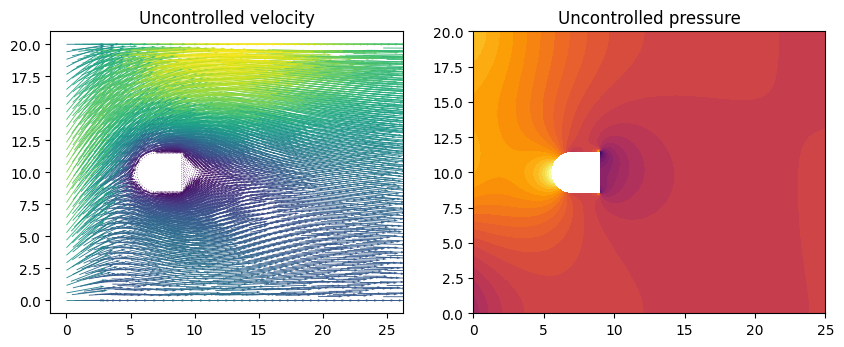

In [8]:
# SOLVE THE STATE PROBLEM

u = interpolate(Expression(('0.0', '0.0'), degree = 1), Vh)

vp = compute_state([4.0, 1.0], u = u)
v, p = split(vp)

plt.figure(figsize = (10,8))

plt.subplot(1, 2, 1)
plt.title("Uncontrolled velocity");
plot(v, scale = 20)
plt.subplot(1, 2, 2)
plt.title("Uncontrolled pressure");
plot(p, cmap = "inferno")
plt.show()

# Snapshots generation

### PDE-constrained Optimisation

Consider the problem of minimising the drag coefficient

$$
\min_{\boldsymbol{v},\boldsymbol{u}} \frac{1}{2} \int_{\Omega} ||\nabla \boldsymbol{v}||^2 + \frac{\beta}{2} \int_{\Gamma_{\textrm{c}}} ||\boldsymbol{u}||^2  + \frac{\beta_g}{2} 
\int_{\Gamma_{\textrm{c}}} ||\nabla \boldsymbol{u}||^2  \\
$$

Physically, this setup corresponds to minimising the loss of flow energy into heat by actively controlling the inflow/outflow at a portion of the obstacle boundary. To avoid overconsuming and irregular control solutions, the norms of the control and its gradient are penalised via the regularisation terms.

In [ ]:
# GENERATE SNAPSHOTS

from dlroms.ocp import snapshots

nsnapshots = 50
ntrain = 40
nparams = 2

beta = Constant(0.01)
beta_g = Constant(0.01)

ranges = [(10.0, 130.0), (-1.0, 1.0)] # Scenario paramters: mod_in, alpha_in

set_working_tape(Tape()) # Reset forward model annotated by dolfin adjoint 

def sampler(seed):
    """
    Generate a random sample of scenario parameters and the corresponding optimal pair
    Input: seed
    Output: scenario parameters, optimal state and control
    """
    params = [0] * len(ranges)
    for i in range(len(ranges)):
        params[i] = ((ranges[i][1] - ranges[i][0]) * CPU.rand() + ranges[i][0]).item()    
    
    u = interpolate(Expression(('0.0', '0.0'), degree = 1), Vh) # Control initialization

    vp = compute_state(params, u)
    v, p = split(vp)

    J = assemble(0.5 * inner(grad(v), grad(v)) * dx + 0.5 * beta * inner(u, u) * ds(2) + 0.5 * beta_g * inner(grad(u), grad(u)) * ds(2))
    control = Control(u)      
    Jhat = ReducedFunctional(J, control)
    
    u_opt = minimize(Jhat, method = 'L-BFGS-B', options = {'disp': True, 'maxiter': 100})
    vp_opt = compute_state(params, u_opt)

    v_opt = interpolate(vp_opt.sub(0), Vh)

    set_working_tape(Tape())    
   
    return params, v_opt.vector(), u_opt.vector()[idx_control]

snapshots(nsnapshots, sampler, core = CPU, verbose = True, filename = 'Data/SteadyNavier-Stokes')

In [9]:
# LOAD SNAPSHOTS MATRICES

nsnapshots = 50
ntrain = 40
nparams = 2

ranges = [(10.0, 130.0), (-1.0, 1.0)] # Scenario paramters: mod_in, alpha_in

filename = 'Data/SteadyNavier-Stokes'
Data = np.load("%s.npz" % filename.replace(".npz",""))

MU = CPU.tensor(Data["mu"])
V = CPU.tensor(Data["y"])
U = CPU.tensor(Data["u"])

In [10]:
# SPLIT MATRICES OF VECTOR FIELDS

Vx = V[:, 0 : nv : 2]
Vy = V[:, 1 : nv : 2]
Ux = U[:, 0 : nu : 2]
Uy = U[:, 1 : nu : 2]

In [11]:
# CREATE MATRICES WITH CONTROL ON THE ENTIRE DOMAIN TO COMPUTE ERRORS

Ux_extended = CPU.zeros(nsnapshots, nv // 2)
Uy_extended = CPU.zeros(nsnapshots, nv // 2)
Ux_extended[:, idx_control_x[0 : nv : 2]] = Ux
Uy_extended[:, idx_control_y[1 : nv : 2]] = Uy

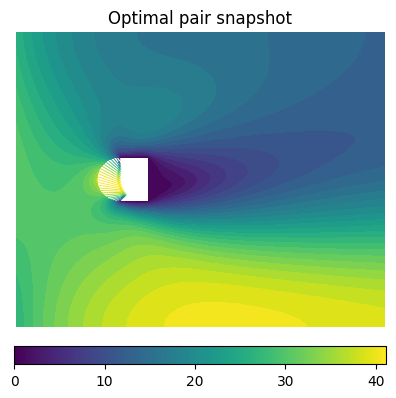

In [12]:
# SNAPSHOT EXAMPLE (PLOT)

which = 0

v = Function(Vh)
v.vector()[:] = V[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
u = CPU.zeros(nv)
u[idx_control] = U[which]
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 0.75, orientation = "horizontal", pad = 0.05)
fe.plot(u, Vh, colorbar = False, scale = 500, minlength = 0)
plt.title("Optimal pair snapshot");
plt.axis('off');

# POD-NN

In [13]:
# IMPORT FUNCTIONS FOR POD AND NEURAL NETWORKS

from dlroms.dnns import Dense # Neural networks handling
from dlroms.roms import projectup, mre, mse, euclidean # Proper orthogonal decomposition
from dlroms.ocp import L2, Linf # Error metrics

l2_state = L2(mesh, Vh, measure = dx, core = CPU)
l2_control = L2(mesh, Vh, measure = ds(2), core = CPU)
linf = Linf()

mse = mse(euclidean)
mre = mre(euclidean)

In [14]:
# DEFINE THE OCP OBJECT TO HANDLE REDUCTIONS AND PREDICTIONS

from dlroms.ocp import OCP

ocp = OCP(ntrain)

## State reduction - POD

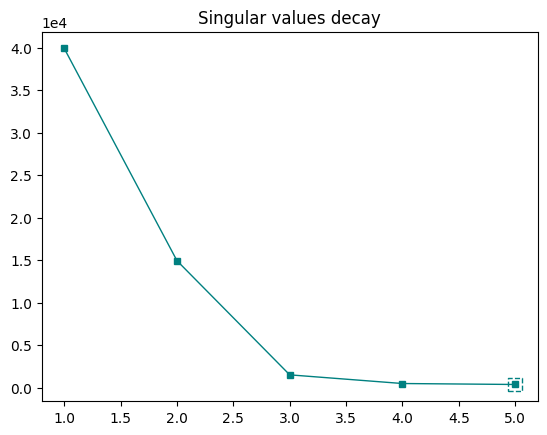

In [15]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Vx

n_Vx = k_Vx = 5 # Number of POD modes

Vx_POD, Vx_reconstructed, pod_Vx, eig_Vx = ocp.POD(Vx, k = k_Vx, color = teal[14])

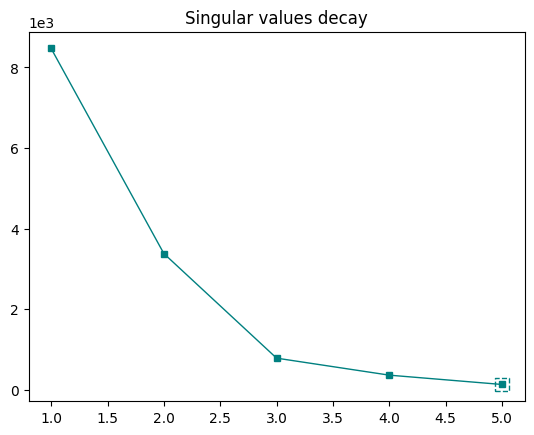

In [16]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Vy

n_Vy = k_Vy = 5 # Number of POD modes

Vy_POD, Vy_reconstructed, pod_Vy, eig_Vy = ocp.POD(Vy, k = k_Vy, color = teal[14])

In [17]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("POD reconstruction errors:")
print("")
print("Mean relative error on Vx: %s." % num2p(mre(Vx[ntrain:], Vx_reconstructed[ntrain:])))
print("Mean relative error on Vy: %s." % num2p(mre(Vy[ntrain:], Vy_reconstructed[ntrain:])))
print("L2 mean relative error on Vx: %s." % num2p(l2_state.mre(Vx[ntrain:], Vx_reconstructed[ntrain:])))
print("L2 mean relative error on Vy: %s." % num2p(l2_state.mre(Vy[ntrain:], Vy_reconstructed[ntrain:])))
print("L2 mean relative error on V: %s." % num2p(l2_state.mre_vect(Vx[ntrain:], Vx_reconstructed[ntrain:], Vy[ntrain:], Vy_reconstructed[ntrain:])))

POD reconstruction errors:

Mean relative error on Vx: 0.81%.
Mean relative error on Vy: 1.99%.
L2 mean relative error on Vx: 0.67%.
L2 mean relative error on Vy: 1.73%.
L2 mean relative error on V: 0.73%.


## Control reduction - POD

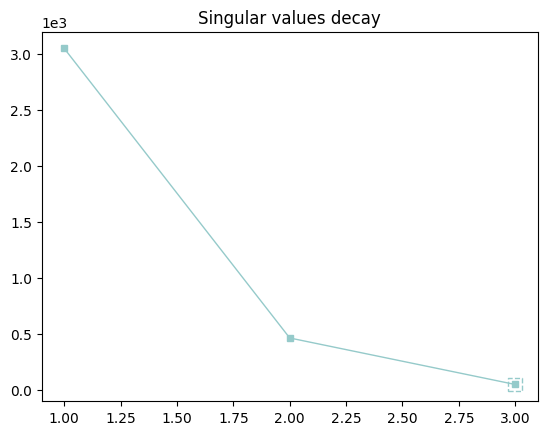

In [18]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Ux

n_Ux = k_Ux = 3 # Number of POD modes

Ux_POD, Ux_reconstructed, pod_Ux, eig_Ux = ocp.POD(Ux, k = k_Ux, color = teal[5])

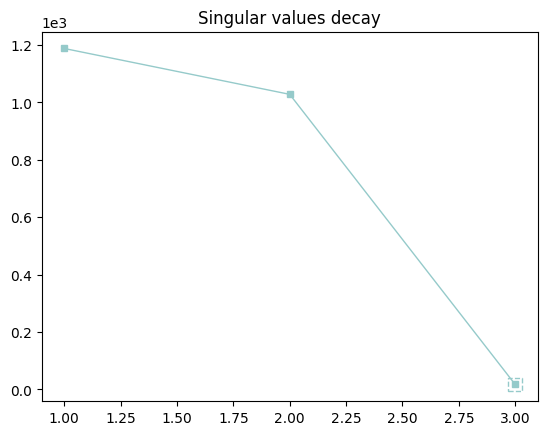

In [19]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR Uy

n_Uy = k_Uy = 3 # Number of POD modes

Uy_POD, Uy_reconstructed, pod_Uy, eig_Uy = ocp.POD(Uy, k = k_Uy, color = teal[5])

In [20]:
# POD reconstruction errors on test data

Ux_POD_extended = CPU.zeros(nsnapshots, nv // 2)
Uy_POD_extended = CPU.zeros(nsnapshots, nv // 2)
Ux_POD_extended[:, idx_control_x[0 : nv : 2]] = Ux_reconstructed
Uy_POD_extended[:, idx_control_y[1 : nv : 2]] = Uy_reconstructed

print("POD reconstruction errors:")
print("")
print("Mean relative error on Ux: %s." % num2p(mre(Ux[ntrain:], projectup(pod_Ux, Ux_POD)[ntrain:])))
print("Mean relative error on Uy: %s." % num2p(mre(Uy[ntrain:], projectup(pod_Uy, Uy_POD)[ntrain:])))
print("L2 mean relative error on Ux: %s." % num2p(l2_control.mre(Ux_extended[ntrain:], Ux_POD_extended[ntrain:])))
print("L2 mean relative error on Uy: %s." % num2p(l2_control.mre(Uy_extended[ntrain:], Uy_POD_extended[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux_extended[ntrain:], Ux_POD_extended[ntrain:], Uy_extended[ntrain:], Uy_POD_extended[ntrain:])))

POD reconstruction errors:

Mean relative error on Ux: 0.42%.
Mean relative error on Uy: 1.36%.
L2 mean relative error on Ux: 0.40%.
L2 mean relative error on Uy: 1.29%.
L2 mean relative error on U: 0.70%.


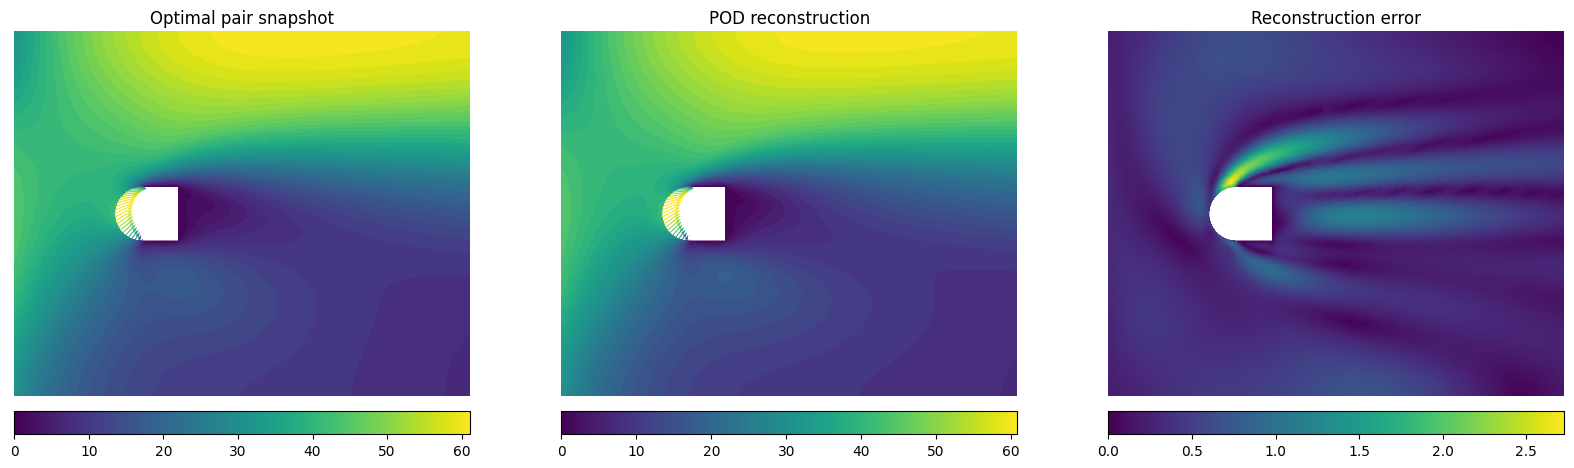

In [21]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

U_reconstruction = CPU.zeros(nsnapshots, nu)
U_reconstruction[:, 0 : nu : 2] = projectup(pod_Ux, Ux_POD)
U_reconstruction[:, 1 : nu : 2] = projectup(pod_Uy, Uy_POD)

V_reconstruction = CPU.zeros(nsnapshots, nv)
V_reconstruction[:, 0 : nv : 2] = projectup(pod_Vx, Vx_POD)
V_reconstruction[:, 1 : nv : 2] = projectup(pod_Vy, Vy_POD)

plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
u = CPU.zeros(nv)
u[idx_control] = U[which]
v = Function(Vh)
v.vector()[:] = V[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 900, minlength = 0)
plt.title("Optimal pair snapshot");
plt.axis('off');

plt.subplot(1,3,2)
u = CPU.zeros(nv)
u[idx_control] = U_reconstruction[which]
v = Function(Vh)
v.vector()[:] = V_reconstruction[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 900, minlength = 0)
plt.title("POD reconstruction");
plt.axis('off');

plt.subplot(1,3,3)
u = CPU.zeros(nv)
u[idx_control] = ((U[which] - U_reconstruction[which])**2).sqrt()
v = Function(Vh)
v.vector()[:] = V[which] - V_reconstruction[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
plot(v_norm)
fig = plot(v_norm, vmin = 0.0, mode = "color")
plt.colorbar(fig, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 1250, minlength = 0)
plt.title("Reconstruction error");
plt.axis('off');

## Parameter-to-solution map $\boldsymbol{\mu}_s \to (\mathbf{u}_{POD}, \mathbf{y}_{POD})$ 

In [22]:
# NORMALIZATION OF THE INPUT MATRIX 

MU_std = MU.detach().clone()
MUmin, idx = torch.min(MU, dim = 0)
MUmax, idx = torch.max(MU, dim = 0)
for i in range(nparams):
    MU_std[:,i] = (MU_std[:,i] - MUmin[i]) / (MUmax[i] - MUmin[i])

In [23]:
# NN TO MAP PARAMETERS IN REDUCED OPTIMAL STATE AND CONTROL

phi = Dense(nparams, 100) + Dense(100, 100) + Dense(100, 100) + Dense(100, n_Vx + n_Vy + n_Ux + n_Uy, activation = None)

VU_POD = [Vx_POD, Vy_POD, Ux_POD, Uy_POD]

VU_POD_hat = ocp.redmap(phi, MU_std, VU_POD, minmax = True, load = True, training = False, save = False, path = 'NN/SteadyFlowControl/phi.pt', epochs = 500, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [24]:
# POD-NN PREDICTION ERRORS ON TEST DATA

Vx_POD_hat = VU_POD_hat[0]
Vy_POD_hat = VU_POD_hat[1]
Ux_POD_hat = VU_POD_hat[2]
Uy_POD_hat = VU_POD_hat[3]

Vx_hat = projectup(pod_Vx, Vx_POD_hat)
Vy_hat = projectup(pod_Vy, Vy_POD_hat)
Ux_hat = projectup(pod_Ux, Ux_POD_hat)
Uy_hat = projectup(pod_Uy, Uy_POD_hat)

Ux_hat_extended = CPU.zeros(nsnapshots, nv // 2)
Uy_hat_extended = CPU.zeros(nsnapshots, nv // 2)
Ux_hat_extended[:,idx_control_x[0 : nv : 2]] = Ux_hat
Uy_hat_extended[:,idx_control_y[1 : nv : 2]] = Uy_hat

print("POD-NN prediction errors:")
print("")
print("Mean relative error on Vx: %s." % num2p(mre(Vx[ntrain:], Vx_hat[ntrain:])))
print("Mean relative error on Vy: %s." % num2p(mre(Vy[ntrain:], Vy_hat[ntrain:])))
print("L2 mean relative error on Vx: %s." % num2p(l2_state.mre(Vx[ntrain:], Vx_hat[ntrain:])))
print("L2 mean relative error on Vy: %s." % num2p(l2_state.mre(Vy[ntrain:], Vy_hat[ntrain:])))
print("L2 mean relative error on V: %s." % num2p(l2_state.mre_vect(Vx[ntrain:], Vx_hat[ntrain:], Vy[ntrain:], Vy_hat[ntrain:])))
print("")
print("Mean relative error on Ux: %s." % num2p(mre(Ux[ntrain:], Ux_hat[ntrain:])))
print("Mean relative error on Uy: %s." % num2p(mre(Uy[ntrain:], Uy_hat[ntrain:])))
print("L2 mean relative error on Ux: %s." % num2p(l2_control.mre(Ux_extended[ntrain:], Ux_hat_extended[ntrain:])))
print("L2 mean relative error on Uy: %s." % num2p(l2_control.mre(Uy_extended[ntrain:], Uy_hat_extended[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux_extended[ntrain:], Ux_hat_extended[ntrain:], Uy_extended[ntrain:], Uy_hat_extended[ntrain:])))

POD-NN prediction errors:

Mean relative error on Vx: 1.58%.
Mean relative error on Vy: 3.62%.
L2 mean relative error on Vx: 1.42%.
L2 mean relative error on Vy: 3.46%.
L2 mean relative error on V: 1.53%.

Mean relative error on Ux: 1.39%.
Mean relative error on Uy: 2.88%.
L2 mean relative error on Ux: 1.38%.
L2 mean relative error on Uy: 2.83%.
L2 mean relative error on U: 1.81%.


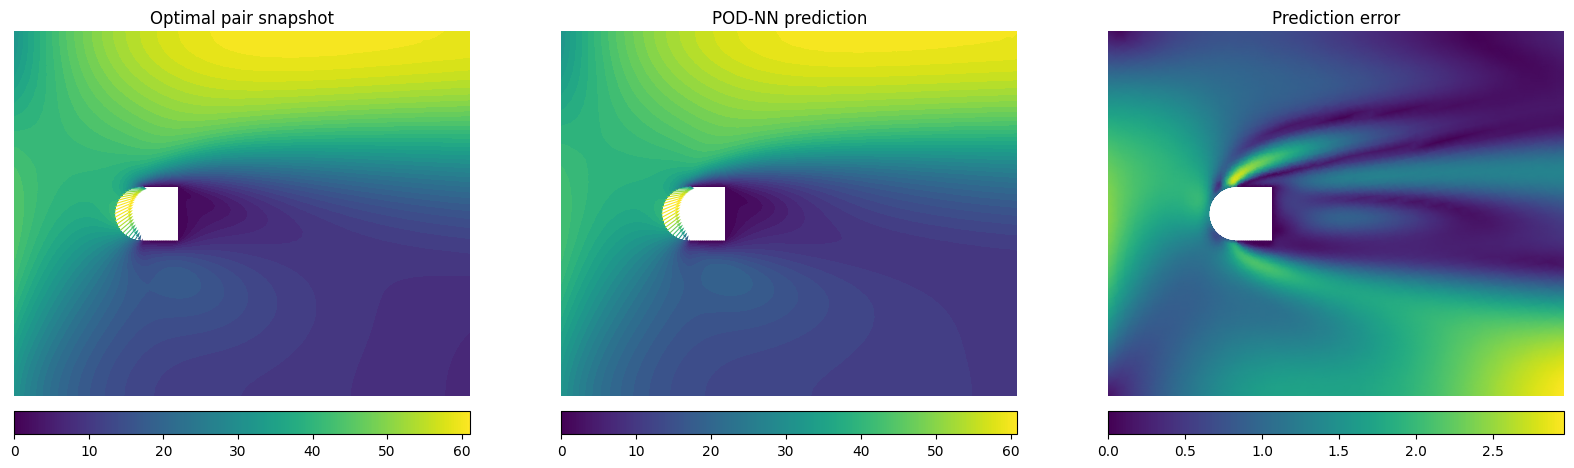

In [25]:
# FOM vs POD-NN PREDEICTION (PLOTS)

which = -1

V_hat = CPU.zeros(nsnapshots, nv)
V_hat[:, 0 : nv : 2] = Vx_hat
V_hat[:, 1 : nv : 2] = Vy_hat

U_hat = CPU.zeros(nsnapshots, nu)
U_hat[:, 0 : nu : 2] = Ux_hat
U_hat[:, 1 : nu : 2] = Uy_hat

plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
u = CPU.zeros(nv)
u[idx_control] = U[which]
v = Function(Vh)
v.vector()[:] = V[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 900, minlength = 0)
plt.title("Optimal pair snapshot");
plt.axis('off');

plt.subplot(1,3,2)
u = CPU.zeros(nv)
u[idx_control] = U_hat[which]
v = Function(Vh)
v.vector()[:] = V_hat[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 900, minlength = 0)
plt.title("POD-NN prediction");
plt.axis('off');

plt.subplot(1,3,3)
u = CPU.zeros(nv)
u[idx_control] = ((U[which] - U_hat[which])**2).sqrt()
v = Function(Vh)
v.vector()[:] = V[which] - V_hat[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
plot(v_norm)
fig = plot(v_norm, vmin = 0.0, mode = "color")
plt.colorbar(fig, shrink = 1, orientation = "horizontal", pad = 0.01, format = "%.1f")
fe.plot(u, Vh, colorbar = False, scale = 1250, minlength = 0)
plt.title("Prediction error");
plt.axis('off');

# Test case: solve the OCP for different angles of attack

In [26]:
# CREATE TEST PARAMETERS

nangles = 10 # Number of angles to investigate
mod_in_test = 50.0 # Fixed inflow intensity

MU_test = CPU.zeros(nangles, nparams)
MU_test_std = CPU.zeros(nangles, nparams)

for i in range(nangles):
    MU_test[i,0] = mod_in_test
    MU_test[i,1] = sin(i / 2 / pi)
    
for i in range(nparams):
    MU_test_std[:,i] = (MU_test[:,i] - MUmin[i]) / (MUmax[i] - MUmin[i])

In [27]:
# COMPUTE OPTIMAL STATE AND CONTROL

Vx_test_POD_hat, Vy_test_POD_hat, Ux_test_POD_hat, Uy_test_POD_hat = ocp.redmap(phi, MU_test_std, VU_POD, minmax = True, training = False, save = False)

Vx_test_hat = projectup(pod_Vx, Vx_test_POD_hat)
Vy_test_hat = projectup(pod_Vy, Vy_test_POD_hat)
Ux_test_hat = projectup(pod_Ux, Ux_test_POD_hat)
Uy_test_hat = projectup(pod_Uy, Uy_test_POD_hat)

V_test_hat = CPU.zeros(nangles, nv)
V_test_hat[:, 0 : nv : 2] = Vx_test_hat
V_test_hat[:, 1 : nv : 2] = Vy_test_hat

U_test_hat = CPU.zeros(nangles, nu)
U_test_hat[:, 0 : nu : 2] = Ux_test_hat
U_test_hat[:, 1 : nu : 2] = Uy_test_hat

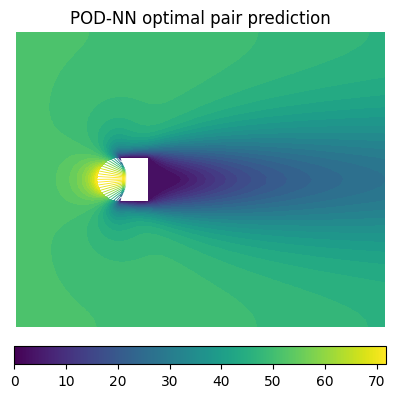

In [28]:
# POD-NN PREDICTION (PLOT)

which = 0

u = CPU.zeros(nv)
u[idx_control] = U_test_hat[which]
v = Function(Vh)
v.vector()[:] = V_test_hat[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 0.75, orientation = "horizontal", pad = 0.05)
fe.plot(u, Vh, colorbar = False, scale = 900, minlength = 0)
plt.title("POD-NN optimal pair prediction");
plt.axis('off');